# Operational Efficiency Benchmarking for Candy Distribution

## Load Data

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [279]:
raw_data_path_prefix = 'data/raw/'

tables_dict = {
    'Sales': 'Candy_Sales.csv',
    'Factories': 'Candy_Factories.csv',
    'Products': 'Candy_Products.csv',
    'Targets': 'Candy_Targets.csv',
    'US Zips': 'uszips.csv',
}

df_sales = pd.read_csv(raw_data_path_prefix + tables_dict['Sales'])
df_factories = pd.read_csv(raw_data_path_prefix + tables_dict['Factories'])
df_products = pd.read_csv(raw_data_path_prefix + tables_dict['Products'])
df_targets = pd.read_csv(raw_data_path_prefix + tables_dict['Targets'])
df_zips = pd.read_csv(raw_data_path_prefix + tables_dict['US Zips'])

In [280]:
df_dict = {
    'Sales': df_sales,
    'Factories': df_factories,
    'Products': df_products,
    'Targets': df_targets,
    'US Zips': df_zips
}

In [281]:
for df_name, df in df_dict.items():
    print(f'{df_name}:\n{df.shape}\nContains null values: {df.isnull().sum().any()}\n')

Sales:
(10194, 18)
Contains null values: False

Factories:
(5, 3)
Contains null values: False

Products:
(15, 6)
Contains null values: False

Targets:
(3, 2)
Contains null values: False

US Zips:
(33787, 18)
Contains null values: True



## Clean `df_zips`

In [282]:
df_zips.isnull().sum()

zip                     0
lat                     0
lng                     0
city                    0
state_id                0
state_name              0
zcta                    0
parent_zcta         33787
population             17
density                17
county_fips             0
county_name             0
county_weights          0
county_names_all        0
county_fips_all         0
imprecise               0
military                0
timezone                0
dtype: int64

In [283]:
df_zips['parent_zcta'].unique()

array([nan])

In [284]:
df_zips.drop('parent_zcta', axis=1, inplace=True)

In [285]:
df_zips.isnull().sum()

zip                  0
lat                  0
lng                  0
city                 0
state_id             0
state_name           0
zcta                 0
population          17
density             17
county_fips          0
county_name          0
county_weights       0
county_names_all     0
county_fips_all      0
imprecise            0
military             0
timezone             0
dtype: int64

In [286]:
df_zips[df_zips['population'].isnull()]

,zip,lat,lng,city,state_id,state_name,zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
91,802,18.34349,-64.92870,St Thomas,VI,Virgin Islands,True,NaN,NaN,78030,St. Thomas,"{""78030"": 100}",St. Thomas,78030,False,False,America/St_Thomas
92,820,17.73880,-64.70695,Christiansted,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
93,830,18.33857,-64.73802,St John,VI,Virgin Islands,True,NaN,NaN,78020,St. John,"{""78020"": 100}",St. John,78020,False,False,America/St_Thomas
94,840,17.72649,-64.84717,Frederiksted,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
95,850,17.72763,-64.79122,Kingshill,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
96,851,17.74757,-64.78737,Kingshill,VI,Virgin Islands,True,NaN,NaN,78010,St. Croix,"{""78010"": 100}",St. Croix,78010,False,False,America/St_Thomas
32479,96799,-14.21984,-170.37005,Pago Pago,AS,American Samoa,True,NaN,NaN,60050,Western,"{""60050"": 36.49, ""60010"": 32.58, ""60020"": 29.1...",Western|Eastern|Manu'a|Swains Island,60050|60010|60020|60040,False,False,Pacific/Pago_Pago
32500,96910,13.45472,144.75128,Hagatna,GU,Guam,True,NaN,NaN,66010,Guam,"{""66010"": 100}",Guam,66010,False,False,Pacific/Guam
32501,96913,13.47825,144.81519,Barrigada,GU,Guam,True,NaN,NaN,66010,Guam,"{""66010"": 100}",Guam,66010,False,False,Pacific/Guam
32502,96915,13.37526,144.70714,Santa Rita,GU,Guam,True,NaN,NaN,66010,Guam,"{""66010"": 100}",Guam,66010,False,False,Pacific/Guam


In [287]:
df_zips.drop_duplicates(inplace=True)

In [288]:
def fill_missing_values_native(df, column, group_column):
    df[column] = df[column].fillna(df.groupby(group_column)[column].transform('mean'))

fill_missing_values_native(df_zips, 'population', 'county_name')
fill_missing_values_native(df_zips, 'population', 'state_name')
fill_missing_values_native(df_zips, 'density', 'county_name')
fill_missing_values_native(df_zips, 'density', 'state_name')

In [289]:
population_dict = {
    'Guam': 154000,
    'Northern Mariana Islands': 48000,
    'American Samoa': 50000
}

density_dict = {
    'Guam': 313,
    'Northern Mariana Islands': 96,
    'American Samoa': 259
}

for state, population in population_dict.items():
    df_zips.loc[(df_zips['population'].isnull()) & (df_zips['state_name'] == state), 'population'] = population
    df_zips.loc[(df_zips['density'].isnull()) & (df_zips['state_name'] == state), 'density'] = density_dict[state]

In [290]:
for df_name, df in df_dict.items():
    print(f'{df_name}:\n{df.shape}\nContains null values: {df.isnull().sum().any()}\n')

Sales:
(10194, 18)
Contains null values: False

Factories:
(5, 3)
Contains null values: False

Products:
(15, 6)
Contains null values: False

Targets:
(3, 2)
Contains null values: False

US Zips:
(33787, 17)
Contains null values: False



In [291]:
# Fix df_zips column naming scheme
name_mapping = {
    'zip': 'Postal Code',
    'lat': 'Latitude',
    'lng': 'Longitude',
    'city': 'City',
    'state_id': 'State ID',
    'state_name': 'State Name',
    'zcta': 'ZCTA',
    'population': 'Population',
    'density': 'Density',
    'county_fips': 'County FIPS',
    'county_name': 'County Name',
    'county_weights': 'County Weights',
    'county_names_all': 'County Names All',
    'county_fips_all': 'County FIPS All',
    'imprecise': 'Imprecise',
    'military': 'Military',
    'timezone': 'Timezone'
}

df_zips.rename(columns=name_mapping, inplace=True)

df_zips['Postal Code'] = df_zips['Postal Code'].astype(object)

## Check Remaining Columns

### Factories Table

In [292]:
df_factories.head()

,Factory,Latitude,Longitude
0,Lot's O' Nuts,32.881893,-111.768036
1,Wicked Choccy's,32.076176,-81.088371
2,Sugar Shack,48.119140,-96.181150
3,Secret Factory,41.446333,-90.565487
4,The Other Factory,35.117500,-89.971107


In [293]:
df_factories.describe(include='all')

,Factory,Latitude,Longitude
count,5,5.000000,5.000000
unique,5,NaN,NaN
top,Lot's O' Nuts,NaN,NaN
freq,1,NaN,NaN
mean,NaN,37.928208,-93.914830
std,NaN,6.779453,11.348593
min,NaN,32.076176,-111.768036
25%,NaN,32.881893,-96.181150
50%,NaN,35.117500,-90.565487
75%,NaN,41.446333,-89.971107


In [294]:
df_factories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Factory    5 non-null      object 
 1   Latitude   5 non-null      float64
 2   Longitude  5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 252.0+ bytes


In [295]:
df_factories['Factory'].unique()

array(["Lot's O' Nuts", "Wicked Choccy's", 'Sugar Shack',
       'Secret Factory', 'The Other Factory'], dtype=object)

### Sales Table

In [296]:
df_sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
0,282,US-2021-128055-CHO-TRI-54000,2021-03-31,2026-09-26,Standard Class,128055,United States,San Francisco,California,94122,Chocolate,Pacific,CHO-TRI-54000,Wonka Bar - Triple Dazzle Caramel,7.50,2,4.90,2.60
1,288,US-2021-128055-CHO-SCR-58000,2021-03-31,2026-09-26,Standard Class,128055,United States,San Francisco,California,94122,Chocolate,Pacific,CHO-SCR-58000,Wonka Bar -Scrumdiddlyumptious,7.20,2,5.00,2.20
2,1132,US-2021-138100-CHO-FUD-51000,2021-09-15,2027-03-13,Standard Class,138100,United States,New York City,New York,10011,Chocolate,Atlantic,CHO-FUD-51000,Wonka Bar - Fudge Mallows,7.20,2,4.80,2.40
3,1133,US-2021-138100-CHO-MIL-31000,2021-09-15,2027-03-13,Standard Class,138100,United States,New York City,New York,10011,Chocolate,Atlantic,CHO-MIL-31000,Wonka Bar - Milk Chocolate,9.75,3,6.33,3.42
4,3396,US-2022-121391-CHO-MIL-31000,2022-10-04,2028-03-29,First Class,121391,United States,San Francisco,California,94109,Chocolate,Pacific,CHO-MIL-31000,Wonka Bar - Milk Chocolate,6.50,2,4.22,2.28


In [297]:
df_sales.describe(include='all')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
count,10194.000000,10194,10194,10194,10194,10194.000000,10194,10194,10194,10194,10194,10194,10194,10194,10194.000000,10194.000000,10194.000000,10194.000000
unique,NaN,8549,1242,1338,4,NaN,2,542,59,654,3,4,15,15,NaN,NaN,NaN,NaN
top,NaN,US-2024-100111-CHO-NUT-13000,2023-09-05,2028-06-07,Standard Class,NaN,United States,New York City,California,10035,Chocolate,Pacific,CHO-MIL-31000,Wonka Bar - Milk Chocolate,NaN,NaN,NaN,NaN
freq,NaN,5,38,38,6120,NaN,9994,915,2001,263,9844,3253,2137,2137,NaN,NaN,NaN,NaN
mean,5097.500000,NaN,NaN,NaN,NaN,134468.961154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.908537,3.791838,9.166451,4.742087
std,2942.898656,NaN,NaN,NaN,NaN,20231.483007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.341020,2.228317,6.643740,5.061647
min,1.000000,NaN,NaN,NaN,NaN,100006.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.000000,0.250000,0.600000
25%,2549.250000,NaN,NaN,NaN,NaN,117212.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.200000,2.000000,4.900000,2.400000
50%,5097.500000,NaN,NaN,NaN,NaN,133550.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.800000,3.000000,7.470000,3.600000
75%,7645.750000,NaN,NaN,NaN,NaN,152051.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,5.000000,12.250000,5.700000


In [298]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          10194 non-null  int64  
 1   Order ID        10194 non-null  object 
 2   Order Date      10194 non-null  object 
 3   Ship Date       10194 non-null  object 
 4   Ship Mode       10194 non-null  object 
 5   Customer ID     10194 non-null  int64  
 6   Country/Region  10194 non-null  object 
 7   City            10194 non-null  object 
 8   State/Province  10194 non-null  object 
 9   Postal Code     10194 non-null  object 
 10  Division        10194 non-null  object 
 11  Region          10194 non-null  object 
 12  Product ID      10194 non-null  object 
 13  Product Name    10194 non-null  object 
 14  Sales           10194 non-null  float64
 15  Units           10194 non-null  int64  
 16  Gross Profit    10194 non-null  float64
 17  Cost            10194 non-null 

In [299]:
# Convert Date Columns
df_sales['Order Date'] = pd.to_datetime(df_sales['Order Date'])
df_sales['Ship Date'] = pd.to_datetime(df_sales['Ship Date'])

In [300]:
df_sales['Order ID'].value_counts()

Order ID
US-2024-100111-CHO-NUT-13000    5
US-2024-113278-CHO-MIL-31000    5
US-2021-155502-CHO-MIL-31000    5
US-2024-104731-CHO-FUD-51000    5
US-2022-126977-CHO-SCR-58000    5
                               ..
US-2024-106943-CHO-FUD-51000    1
US-2024-141992-CHO-NUT-13000    1
US-2024-141992-CHO-TRI-54000    1
US-2024-107979-CHO-MIL-31000    1
US-2024-141481-CHO-FUD-51000    1
Name: count, Length: 8549, dtype: int64

In [301]:
df_sales['Product ID'].value_counts()

Product ID
CHO-MIL-31000    2137
CHO-SCR-58000    2064
CHO-TRI-54000    2015
CHO-FUD-51000    1818
CHO-NUT-13000    1810
OTH-GUM-21000     120
OTH-KAZ-38000      96
OTH-LIC-15000      94
SUG-SWE-91000      10
SUG-LAF-25000      10
OTH-FIZ-56000       6
SUG-NER-92000       4
SUG-HAI-55000       4
SUG-EVE-47000       3
SUG-FUN-75000       3
Name: count, dtype: int64

### Products Table

In [302]:
df_products.head()

,Division,Product Name,Factory,Product ID,Unit Price,Unit Cost
0,Chocolate,Wonka Bar - Nutty Crunch Surprise,Lot's O' Nuts,CHO-NUT-13000,3.49,1.00
1,Chocolate,Wonka Bar - Fudge Mallows,Lot's O' Nuts,CHO-FUD-51000,3.60,1.20
2,Chocolate,Wonka Bar -Scrumdiddlyumptious,Lot's O' Nuts,CHO-SCR-58000,3.60,1.10
3,Chocolate,Wonka Bar - Milk Chocolate,Wicked Choccy's,CHO-MIL-31000,3.25,1.14
4,Chocolate,Wonka Bar - Triple Dazzle Caramel,Wicked Choccy's,CHO-TRI-54000,3.75,1.30


In [303]:
df_products['Division'].unique()

array(['Chocolate', 'Sugar', 'Other'], dtype=object)

In [304]:
df_products.describe(include='all')

,Division,Product Name,Factory,Product ID,Unit Price,Unit Cost
count,15,15,15,15,15.000000,15.000000
unique,3,15,5,15,NaN,NaN
top,Sugar,Wonka Bar - Nutty Crunch Surprise,Sugar Shack,CHO-NUT-13000,NaN,NaN
freq,6,1,5,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,4.462000,1.806000
std,NaN,NaN,NaN,NaN,4.790102,2.344866
min,NaN,NaN,NaN,NaN,1.250000,0.600000
25%,NaN,NaN,NaN,NaN,1.745000,0.850000
50%,NaN,NaN,NaN,NaN,3.490000,1.100000
75%,NaN,NaN,NaN,NaN,3.750000,1.400000


In [305]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Division      15 non-null     object 
 1   Product Name  15 non-null     object 
 2   Factory       15 non-null     object 
 3   Product ID    15 non-null     object 
 4   Unit Price    15 non-null     float64
 5   Unit Cost     15 non-null     float64
dtypes: float64(2), object(4)
memory usage: 852.0+ bytes


### Targets Table

In [306]:
df_targets.head()

,Division,Target
0,Chocolate,27000
1,Sugar,15000
2,Other,3000


In [307]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  3 non-null      object
 1   Target    3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 180.0+ bytes


## Remove Duplicates

In [308]:
df_sales.drop_duplicates(inplace=True)
df_products.drop_duplicates(inplace=True)
df_targets.drop_duplicates(inplace=True)
df_zips.drop_duplicates(inplace=True)
df_factories.drop_duplicates(inplace=True)

## Fix Ship Date Scaling

As we are dealing with artificial data, we have observed through our lead time feature engineering (later on in this notebook) that shipping dates are heavily offset by about 2000 days. We will fix this so we can continue our predictions with more realistic data. Obviously this would be different if we were dealing with real-world data, but within the scope of this project this seems to be the best move if we want to continue.

In [309]:
(df_sales['Ship Date'] - df_sales['Order Date']).min()

Timedelta('2000 days 00:00:00')

In [310]:
(df_sales['Ship Date'] - df_sales['Order Date']).max()

Timedelta('2011 days 00:00:00')

In [311]:
df_sales['Ship Date'] -= pd.to_timedelta(1999, unit='d')

In [312]:
(df_sales['Ship Date'] - df_sales['Order Date']).min()

Timedelta('1 days 00:00:00')

In [313]:
(df_sales['Ship Date'] - df_sales['Order Date']).max()

Timedelta('12 days 00:00:00')

## SQLite Database

In [314]:
%load_ext sql
%sql sqlite:///sales_data.db
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [315]:
import sqlite3

conn = sqlite3.connect('sales_data.db')
df_sales.to_sql('Sales', conn, if_exists='replace', index=False)
df_products.to_sql('Products', conn, if_exists='replace', index=False)
df_targets.to_sql('Targets', conn, if_exists='replace', index=False)
df_zips.to_sql('US Zips', conn, if_exists='replace', index=False)
df_factories.to_sql('Factories', conn, if_exists='replace', index=False)

5

## MySQL Database

In [316]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()
mysql_host = os.getenv('MYSQL_HOST')
mysql_user = os.getenv('MYSQL_USER')
mysql_password = os.getenv('MYSQL_PASSWORD')
mysql_name = os.getenv('MYSQL_NAME')

mydb = mysql.connector.connect(host=mysql_host, user=mysql_user, password=mysql_password, database=mysql_name)


cursor = mydb.cursor()

# Insert data from pandas DataFrames into MySQL tables
for table_name, df in [
    ('sales_t', df_sales),
    ('products_t', df_products),
    ('targets_t', df_targets),
    ('us_zips_t', df_zips),
    ('factories_t', df_factories),
]:
    # Check if the table exists
    cursor.execute(f"SHOW TABLES LIKE '{table_name}'")
    table_exists = cursor.fetchone()

    if not table_exists:
        # Prepare the CREATE TABLE query based on the DataFrame schema
        column_definitions = []
        for column, dtype in df.dtypes.items():
            if dtype == 'int64':
                column_definitions.append(f'`{column}` INT')
            elif dtype == 'float64':
                column_definitions.append(f'`{column}` FLOAT')
            elif dtype == 'datetime64[ns]':
                column_definitions.append(f'`{column}` DATETIME')
            else:
                column_definitions.append(f'`{column}` VARCHAR(255)')

        create_table_query = f'CREATE TABLE `{table_name}` ({", ".join(column_definitions)})'
        try:
            cursor.execute(create_table_query)
            print(f'Table {table_name} created successfully.')
        except mysql.connector.Error as err:
            print(f'Error creating table {table_name}: {err}')
            continue  # Skip to the next table if creation fails

    # Check if the table has data
    cursor.execute(f'SELECT COUNT(*) FROM `{table_name}`')
    count = cursor.fetchone()[0]

    if count == 0:
        # Prepare the insert query
        columns = ', '.join(f'`{col}`' for col in df.columns)
        placeholders = ', '.join(['%s'] * len(df.columns))
        insert_query = f'INSERT INTO `{table_name}` ({columns}) VALUES ({placeholders})'

        # Iterate over DataFrame rows and insert into MySQL
        for _, row in df.iterrows():
            try:
                cursor.execute(insert_query, tuple(row))
            except mysql.connector.Error as err:
                print(f'Error inserting into {table_name}: {err}')
                print(f'Problematic row: {row.to_dict()}')
        print(f'Data inserted into {table_name}')
    else:
        print(f'Table {table_name} already has data, skipping insertion')


# Commit the changes and close the connection
mydb.commit()
cursor.close()
mydb.close()

Table sales_t already has data, skipping insertion
Table products_t already has data, skipping insertion
Table targets_t already has data, skipping insertion
Table us_zips_t already has data, skipping insertion
Table factories_t already has data, skipping insertion


### Test Query: Compare Gross Profit vs Target per Division

In [317]:
%%sql
SELECT *
FROM Sales
ORDER BY "Gross Profit" DESC
LIMIT 5

 * sqlite:///sales_data.db
Done.


Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State/Province,Postal Code,Division,Region,Product ID,Product Name,Sales,Units,Gross Profit,Cost
366,US-2021-122336-OTH-LIC-15000,2021-04-13 00:00:00,2021-04-18 00:00:00,Second Class,122336,United States,Philadelphia,Pennsylvania,19140,Other,Atlantic,OTH-LIC-15000,Lickable Wallpaper,260.0,13,130.0,130.0
5828,US-2023-124163-OTH-LIC-15000,2023-09-25 00:00:00,2023-10-01 00:00:00,Standard Class,124163,United States,La Crosse,Wisconsin,54601,Other,Interior,OTH-LIC-15000,Lickable Wallpaper,220.0,11,110.0,110.0
4832,US-2023-107202-OTH-LIC-15000,2023-05-21 00:00:00,2023-05-29 00:00:00,Standard Class,107202,United States,Sparks,Nevada,89431,Other,Pacific,OTH-LIC-15000,Lickable Wallpaper,200.0,10,100.0,100.0
6473,US-2023-164770-OTH-LIC-15000,2023-12-02 00:00:00,2023-12-05 00:00:00,Second Class,164770,United States,Houston,Texas,77036,Other,Interior,OTH-LIC-15000,Lickable Wallpaper,200.0,10,100.0,100.0
6981,US-2024-164147-OTH-LIC-15000,2024-02-02 00:00:00,2024-02-06 00:00:00,First Class,164147,United States,Columbus,Ohio,43229,Other,Atlantic,OTH-LIC-15000,Lickable Wallpaper,180.0,9,90.0,90.0


In [318]:
%%sql
WITH
    DivisionTargets AS (
        SELECT
            Division,
            Target AS TargetGrossProfit
        FROM Targets
    )
SELECT
    s.Division,
    SUM(s."Gross Profit") AS TotalGrossProfit,
    dt.TargetGrossProfit,
    CASE
        WHEN SUM(s."Gross Profit") > dt.TargetGrossProfit THEN 'Exceeds Target'
        ELSE 'Falls Below Target'
    END AS Status,
    ROUND(
        SUM(s."Gross Profit") - dt.TargetGrossProfit,
        2
    ) AS Difference,
    ROUND(
        (
            SUM(s."Gross Profit") - dt.TargetGrossProfit
        ) / dt.TargetGrossProfit * 100,
        2
    ) AS PercentChange
FROM
    Sales s
    LEFT JOIN Products p ON s."Product ID" = p."Product ID"
    JOIN DivisionTargets dt ON s.Division = dt.Division
GROUP BY
    s.Division,
    dt.TargetGrossProfit
LIMIT 5;

 * sqlite:///sales_data.db
Done.


Division,TotalGrossProfit,TargetGrossProfit,Status,Difference,PercentChange
Chocolate,88824.62,27000,Exceeds Target,61824.62,228.98
Other,4333.45,3000,Exceeds Target,1333.45,44.45
Sugar,284.73,15000,Falls Below Target,-14715.27,-98.1


### Testing within Python

In [319]:
sql_query = """
WITH
    DivisionTargets AS (
        SELECT
            Division,
            Target AS TargetGrossProfit
        FROM Targets
    )
SELECT
    s.Division,
    SUM(s."Gross Profit") AS TotalGrossProfit,
    dt.TargetGrossProfit,
    CASE
        WHEN SUM(s."Gross Profit") > dt.TargetGrossProfit THEN 'Exceeds Target'
        ELSE 'Falls Below Target'
    END AS Status,
    ROUND(
        SUM(s."Gross Profit") - dt.TargetGrossProfit,
        2
    ) AS Difference,
    ROUND(
        (
            SUM(s."Gross Profit") - dt.TargetGrossProfit
        ) / dt.TargetGrossProfit * 100,
        2
    ) AS PercentChange
FROM
    Sales s
    LEFT JOIN Products p ON s."Product ID" = p."Product ID"
    JOIN DivisionTargets dt ON s.Division = dt.Division
GROUP BY
    s.Division,
    dt.TargetGrossProfit
LIMIT 5;
"""

cursor = conn.cursor()
cursor.execute(sql_query)
results = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
results_df = pd.DataFrame(results, columns=column_names)

results_df

,Division,TotalGrossProfit,TargetGrossProfit,Status,Difference,PercentChange
0,Chocolate,88824.62,27000,Exceeds Target,61824.62,228.98
1,Other,4333.45,3000,Exceeds Target,1333.45,44.45
2,Sugar,284.73,15000,Falls Below Target,-14715.27,-98.10


### Combine Into Single DataFrame (For EDA)

In [320]:
# Print column names as reference
for df_name, df in df_dict.items():
    print(f'{df_name}\n\n{df.columns}\n————————————————————————————————————')

Sales

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Country/Region', 'City', 'State/Province',
       'Postal Code', 'Division', 'Region', 'Product ID', 'Product Name',
       'Sales', 'Units', 'Gross Profit', 'Cost'],
      dtype='object')
————————————————————————————————————
Factories

Index(['Factory', 'Latitude', 'Longitude'], dtype='object')
————————————————————————————————————
Products

Index(['Division', 'Product Name', 'Factory', 'Product ID', 'Unit Price',
       'Unit Cost'],
      dtype='object')
————————————————————————————————————
Targets

Index(['Division', 'Target'], dtype='object')
————————————————————————————————————
US Zips

Index(['Postal Code', 'Latitude', 'Longitude', 'City', 'State ID',
       'State Name', 'ZCTA', 'Population', 'Density', 'County FIPS',
       'County Name', 'County Weights', 'County Names All', 'County FIPS All',
       'Imprecise', 'Military', 'Timezone'],
      dtype='object')
————————————————————

In [321]:
# Remove duplicated redundant columns

df_sales.drop(columns=['Row ID'], inplace=True)
df_zips.drop(columns=['City', 'Latitude', 'Longitude'], inplace=True)
df_products.drop(columns=['Division', 'Product Name'], inplace=True)

In [322]:
# Merge with left joins
df_combined = pd.merge(df_sales, df_products, how='left', on='Product ID')
df_combined = pd.merge(df_combined, df_factories, how='left', on='Factory')
df_combined = pd.merge(df_combined, df_zips, how='left', on='Postal Code')
df_combined = pd.merge(df_combined, df_targets, how='left', on='Division')

In [323]:
# Remove unnecessary columns
df_combined_modif = df_combined.drop(
    columns=[
        'Order ID',
        'Customer ID',
        'State ID',
        'Product ID',
        'County FIPS',
        'County Name',
        'County Weights',
        'County Names All',
        'County FIPS All',
        'Imprecise',
        'Military',
        'Timezone',
        'Population',
        'Density',
        'ZCTA',
    ]
)

In [324]:
df_combined_modif.head()

,Order Date,Ship Date,Ship Mode,Country/Region,City,State/Province,Postal Code,Division,Region,Product Name,...,Units,Gross Profit,Cost,Factory,Unit Price,Unit Cost,Latitude,Longitude,State Name,Target
0,2021-03-31,2021-04-06,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar - Triple Dazzle Caramel,...,2,4.90,2.60,Wicked Choccy's,3.75,1.30,32.076176,-81.088371,NaN,27000
1,2021-03-31,2021-04-06,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar -Scrumdiddlyumptious,...,2,5.00,2.20,Lot's O' Nuts,3.60,1.10,32.881893,-111.768036,NaN,27000
2,2021-09-15,2021-09-21,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Fudge Mallows,...,2,4.80,2.40,Lot's O' Nuts,3.60,1.20,32.881893,-111.768036,NaN,27000
3,2021-09-15,2021-09-21,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Milk Chocolate,...,3,6.33,3.42,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,NaN,27000
4,2022-10-04,2022-10-08,First Class,United States,San Francisco,California,94109,Chocolate,Pacific,Wonka Bar - Milk Chocolate,...,2,4.22,2.28,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,NaN,27000


### EDA

In [325]:
sns.set_style('whitegrid')

In [326]:
df = df_combined_modif.copy()

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order Date      10194 non-null  datetime64[ns]
 1   Ship Date       10194 non-null  datetime64[ns]
 2   Ship Mode       10194 non-null  object        
 3   Country/Region  10194 non-null  object        
 4   City            10194 non-null  object        
 5   State/Province  10194 non-null  object        
 6   Postal Code     10194 non-null  object        
 7   Division        10194 non-null  object        
 8   Region          10194 non-null  object        
 9   Product Name    10194 non-null  object        
 10  Sales           10194 non-null  float64       
 11  Units           10194 non-null  int64         
 12  Gross Profit    10194 non-null  float64       
 13  Cost            10194 non-null  float64       
 14  Factory         10194 non-null  object        
 15  Un

In [328]:
df.isnull().sum()

Order Date            0
Ship Date             0
Ship Mode             0
Country/Region        0
City                  0
State/Province        0
Postal Code           0
Division              0
Region                0
Product Name          0
Sales                 0
Units                 0
Gross Profit          0
Cost                  0
Factory               0
Unit Price            0
Unit Cost             0
Latitude              0
Longitude             0
State Name        10194
Target                0
dtype: int64

In [329]:
# Drop `State Name` (contains all nulls)
df.drop(columns=['State Name'], inplace=True)

In [330]:
# Export for ease of access
df.to_csv('data/processed/Candy_Distributor_Data_Preprocessed_Merged.csv', index=False)

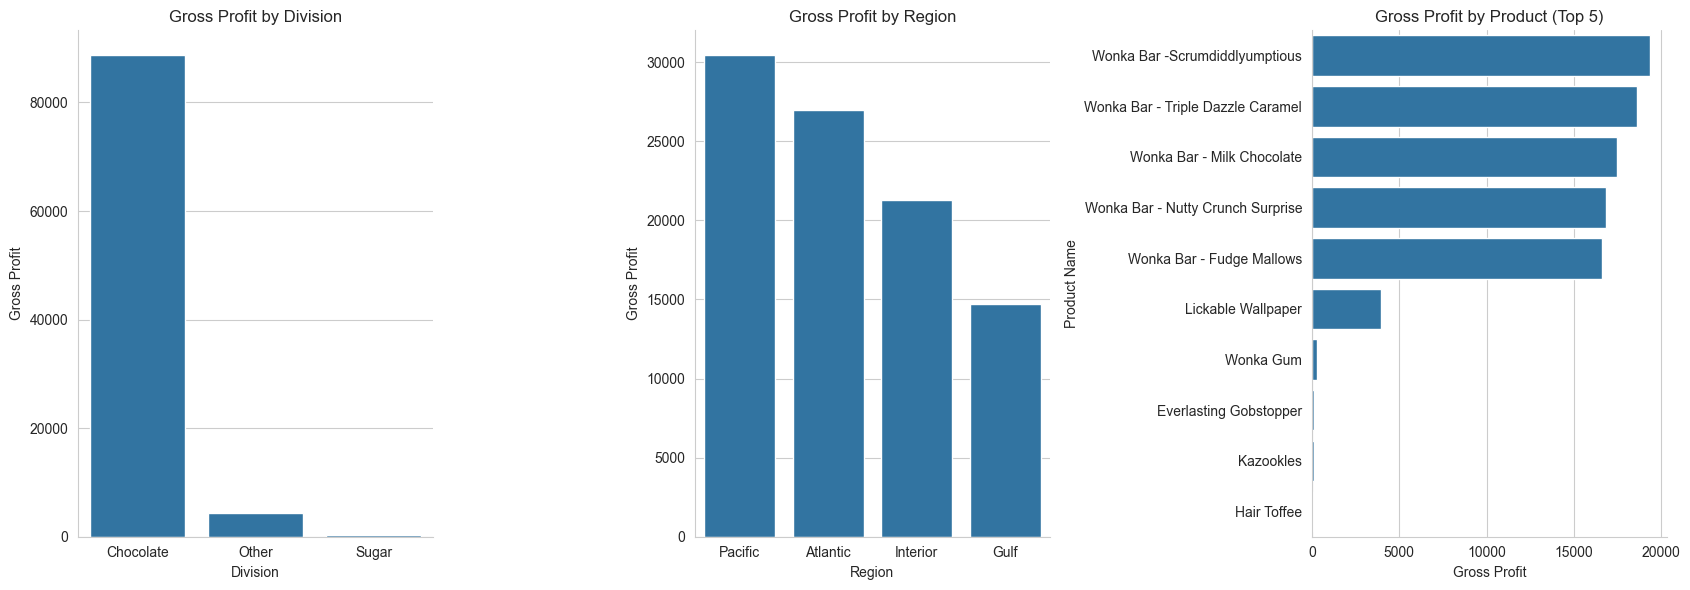

In [331]:
top_10_products_by_profit = df.groupby('Product Name')['Gross Profit'].sum().sort_values(ascending=False).head(10)
df_profit_by_division = df.groupby('Division')['Gross Profit'].sum().sort_values(ascending=False)
df_profit_by_region = df.groupby('Region')['Gross Profit'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(17, 6))

sns.barplot(data=pd.DataFrame(df_profit_by_division), x='Division', y='Gross Profit', ax=axes[0])
axes[0].set_title(f'Gross Profit by Division')
sns.barplot(data=pd.DataFrame(df_profit_by_region), x='Region', y='Gross Profit', ax=axes[1])
axes[1].set_title(f'Gross Profit by Region')
sns.barplot(data=pd.DataFrame(top_10_products_by_profit), y='Product Name', x='Gross Profit', ax=axes[2])
axes[2].set_title(f'Gross Profit by Product (Top 5)')

plt.tight_layout()
sns.despine()
plt.show()

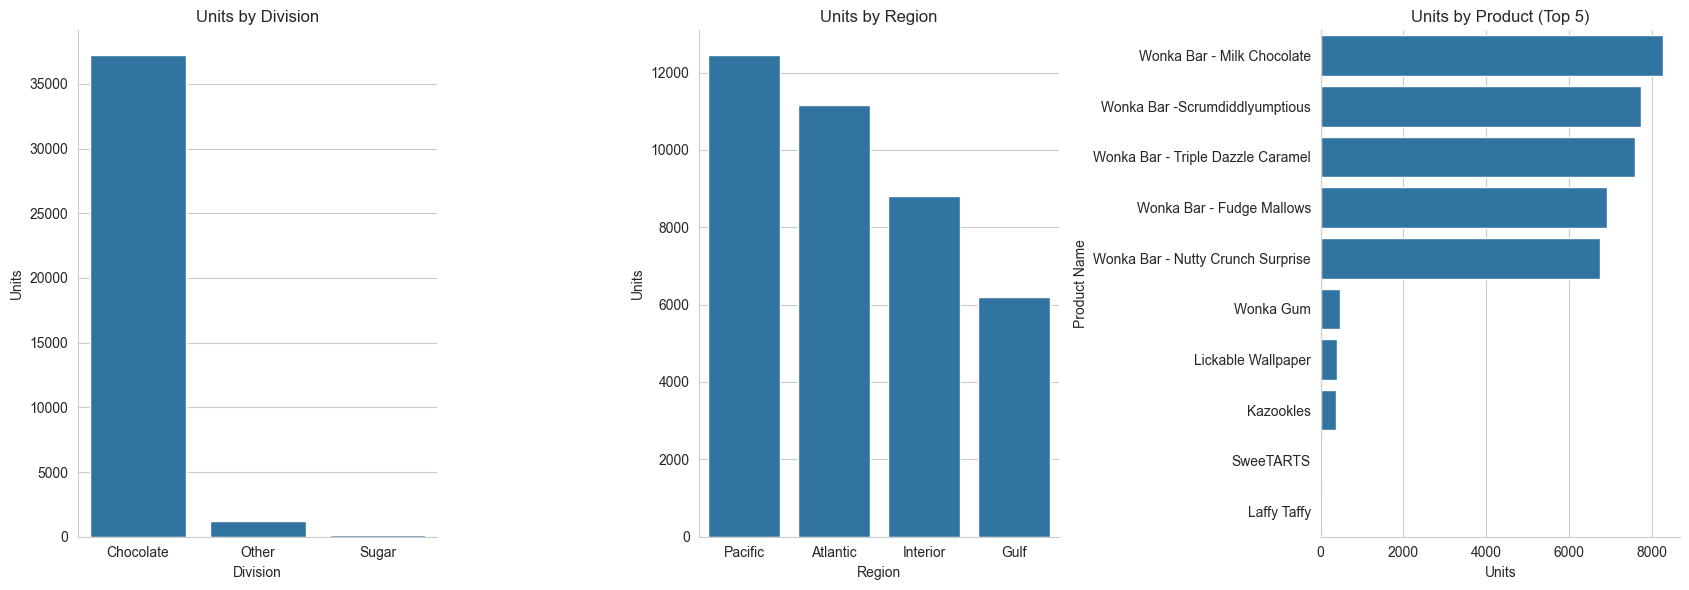

In [332]:
df_units_by_division = df.groupby('Division')['Units'].sum().sort_values(ascending=False)
df_units_by_region = df.groupby('Region')['Units'].sum().sort_values(ascending=False)
top_10_unit_count = df.groupby('Product Name')['Units'].sum().sort_values(ascending=False).head(10)


fig, axes = plt.subplots(1, 3, figsize=(17, 6))

sns.barplot(data=pd.DataFrame(df_units_by_division), x='Division', y='Units', ax=axes[0])
axes[0].set_title(f'Units by Division')
sns.barplot(data=pd.DataFrame(df_units_by_region), x='Region', y='Units', ax=axes[1])
axes[1].set_title(f'Units by Region')
sns.barplot(data=pd.DataFrame(top_10_unit_count), y='Product Name', x='Units', ax=axes[2])
axes[2].set_title(f'Units by Product (Top 5)')

plt.tight_layout()
sns.despine()
plt.show()

## Rename Columns

In [333]:
df.columns.tolist()

['Order Date',
 'Ship Date',
 'Ship Mode',
 'Country/Region',
 'City',
 'State/Province',
 'Postal Code',
 'Division',
 'Region',
 'Product Name',
 'Sales',
 'Units',
 'Gross Profit',
 'Cost',
 'Factory',
 'Unit Price',
 'Unit Cost',
 'Latitude',
 'Longitude',
 'Target']

In [334]:
df.rename(
    columns={
        'Order Date': 'order_date',
        'Ship Date': 'ship_date',
        'Ship Mode': 'ship_mode',
        'Country/Region': 'country_region',
        'City': 'city',
        'State/Province': 'state_province',
        'Postal Code': 'postal_code',
        'Division': 'division',
        'Region': 'region',
        'Product Name': 'product_name',
        'Sales': 'sales',
        'Units': 'units',
        'Gross Profit': 'gross_profit',
        'Cost': 'cost',
        'Factory': 'factory',
        'Unit Price': 'unit_price',
        'Unit Cost': 'unit_cost',
        'Latitude': 'latitude',
        'Longitude': 'longitude',
        'Target': 'target',
    },
    inplace=True
)

## Feature Engineering

### Origin Postal Code Column

We need a way to calculate distances between factory to delivery address. We will assign correct zip codes into a new column per entry.

In [335]:
df[['latitude', 'longitude', 'factory']].value_counts()

latitude   longitude    factory          
32.881893  -111.768036  Lot's O' Nuts        5692
32.076176  -81.088371   Wicked Choccy's      4152
41.446333  -90.565487   Secret Factory        217
35.117500  -89.971107   The Other Factory     100
48.119140  -96.181150   Sugar Shack            33
Name: count, dtype: int64

In [336]:
df['postal_code'].value_counts()

postal_code
10035    263
10024    230
10009    229
94122    203
10011    193
        ... 
93454      1
72032      1
53186      1
08401      1
60025      1
Name: count, Length: 654, dtype: int64

In [337]:
def get_origin_postal_code(row):
    factory_postal_codes = {
        'Lot\'s O\' Nuts': 85122,
        'Wicked Choccy\'s': 31401,
        'Secret Factory': 61264,
        'The Other Factory': 38111,
        'Sugar Shack': 56701
    }
    
    return factory_postal_codes[row['factory']]


df['origin_postal_code'] = df.apply(get_origin_postal_code, axis=1)

In [338]:
df.head()

,order_date,ship_date,ship_mode,country_region,city,state_province,postal_code,division,region,product_name,...,units,gross_profit,cost,factory,unit_price,unit_cost,latitude,longitude,target,origin_postal_code
0,2021-03-31,2021-04-06,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar - Triple Dazzle Caramel,...,2,4.90,2.60,Wicked Choccy's,3.75,1.30,32.076176,-81.088371,27000,31401
1,2021-03-31,2021-04-06,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar -Scrumdiddlyumptious,...,2,5.00,2.20,Lot's O' Nuts,3.60,1.10,32.881893,-111.768036,27000,85122
2,2021-09-15,2021-09-21,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Fudge Mallows,...,2,4.80,2.40,Lot's O' Nuts,3.60,1.20,32.881893,-111.768036,27000,85122
3,2021-09-15,2021-09-21,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Milk Chocolate,...,3,6.33,3.42,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,27000,31401
4,2022-10-04,2022-10-08,First Class,United States,San Francisco,California,94109,Chocolate,Pacific,Wonka Bar - Milk Chocolate,...,2,4.22,2.28,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,27000,31401


### Delivery Distance Column

In [339]:
import pgeocode

dist = pgeocode.GeoDistance('us')

df['distance_km'] = pd.Series(dist.query_postal_code(df['origin_postal_code'].astype(str).to_list(), df['postal_code'].astype(str).to_list()))

In [340]:
df.head()

,order_date,ship_date,ship_mode,country_region,city,state_province,postal_code,division,region,product_name,...,gross_profit,cost,factory,unit_price,unit_cost,latitude,longitude,target,origin_postal_code,distance_km
0,2021-03-31,2021-04-06,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar - Triple Dazzle Caramel,...,4.90,2.60,Wicked Choccy's,3.75,1.30,32.076176,-81.088371,27000,31401,3795.666318
1,2021-03-31,2021-04-06,Standard Class,United States,San Francisco,California,94122,Chocolate,Pacific,Wonka Bar -Scrumdiddlyumptious,...,5.00,2.20,Lot's O' Nuts,3.60,1.10,32.881893,-111.768036,27000,85122,1112.781031
2,2021-09-15,2021-09-21,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Fudge Mallows,...,4.80,2.40,Lot's O' Nuts,3.60,1.20,32.881893,-111.768036,27000,85122,3443.789737
3,2021-09-15,2021-09-21,Standard Class,United States,New York City,New York,10011,Chocolate,Atlantic,Wonka Bar - Milk Chocolate,...,6.33,3.42,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,27000,31401,1152.666776
4,2022-10-04,2022-10-08,First Class,United States,San Francisco,California,94109,Chocolate,Pacific,Wonka Bar - Milk Chocolate,...,4.22,2.28,Wicked Choccy's,3.25,1.14,32.076176,-81.088371,27000,31401,3789.767967


#### Check Nulls

In [341]:
df.isnull().sum()

order_date              0
ship_date               0
ship_mode               0
country_region          0
city                    0
state_province          0
postal_code             0
division                0
region                  0
product_name            0
sales                   0
units                   0
gross_profit            0
cost                    0
factory                 0
unit_price              0
unit_cost               0
latitude                0
longitude               0
target                  0
origin_postal_code      0
distance_km           200
dtype: int64

There's a problem with our approach. It seems that there are now null values. Let's see if we can identify a pattern in the null observations.

In [342]:
df[df['distance_km'].isnull()].head()

,order_date,ship_date,ship_mode,country_region,city,state_province,postal_code,division,region,product_name,...,gross_profit,cost,factory,unit_price,unit_cost,latitude,longitude,target,origin_postal_code,distance_km
113,2021-12-20,2021-12-23,Second Class,Canada,Vancouver,British Columbia,V5K,Chocolate,Pacific,Wonka Bar - Fudge Mallows,...,12.0,6.0,Lot's O' Nuts,3.6,1.2,32.881893,-111.768036,27000,85122,NaN
127,2024-12-20,2024-12-23,Second Class,Canada,Vancouver,British Columbia,V5K,Chocolate,Pacific,Wonka Bar - Fudge Mallows,...,2.4,1.2,Lot's O' Nuts,3.6,1.2,32.881893,-111.768036,27000,85122,NaN
225,2021-09-20,2021-09-23,First Class,Canada,Toronto,Ontario,M2N,Chocolate,Atlantic,Wonka Bar -Scrumdiddlyumptious,...,15.0,6.6,Lot's O' Nuts,3.6,1.1,32.881893,-111.768036,27000,85122,NaN
227,2022-09-20,2022-09-23,First Class,Canada,Toronto,Ontario,M2N,Chocolate,Atlantic,Wonka Bar -Scrumdiddlyumptious,...,5.0,2.2,Lot's O' Nuts,3.6,1.1,32.881893,-111.768036,27000,85122,NaN
238,2023-09-20,2023-09-23,First Class,Canada,Toronto,Ontario,M2N,Chocolate,Atlantic,Wonka Bar -Scrumdiddlyumptious,...,15.0,6.6,Lot's O' Nuts,3.6,1.1,32.881893,-111.768036,27000,85122,NaN


#### Approach to Solving Nulls

We can see that the reasoning behind these nulls is most probably due to a mismatch in countries. As our origin factories still reside in the US, we will be unable to use `pgeocode` to calculate distances.

We must switch our approach in calculating distances for these observations.

Since we have longitude and latitude information for our factories, we just need to calculate the longitude and latitude information for our delivery postal codes.

We can easily do this with two things

  1. `pgeocode` to obtain relevant latitude and longitude info
  2. Haversine Distance function to calculate distance utilizing these two coordinates

##### Haversine Function

In [343]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

##### Get Coordinates From Postal Code Function

In [344]:
def get_lat_lon(postal_code):
    """
    Gets latitude and longitude for a postal code, trying US and Canada.
    Returns (latitude, longitude, country_code) or (None, None, None) if not found.
    """
    nomi_us = pgeocode.Nominatim('us')
    nomi_ca = pgeocode.Nominatim('ca')

    try:
        geo_us = nomi_us.query_postal_code(postal_code)
        if not geo_us.empty and not np.isnan(geo_us.latitude) and not np.isnan(geo_us.longitude):
            return geo_us.latitude, geo_us.longitude, 'us'
    except:
        pass  # Ignore errors, try Canada

    try:
        geo_ca = nomi_ca.query_postal_code(postal_code)
        if not geo_ca.empty and not np.isnan(geo_ca.latitude) and not np.isnan(geo_ca.longitude):
            return geo_ca.latitude, geo_ca.longitude, 'ca'
    except:
        pass

    return None, None, None  # Not found in either country

##### Calculate Distance Function (for use with pandas apply method)

In [345]:
def calculate_distance_for_nulls(row):
    """Calculates distance for a single row where distance_km is null."""
    dest_lat, dest_lon, _ = get_lat_lon(row['postal_code'])

    if dest_lat is not None:  # Only calculate if destination postal code is valid
        return haversine(row['latitude'], row['longitude'], dest_lat, dest_lon)
    else:
        return np.nan

##### Apply Function to Null Observations

In [346]:
# Fill the nulls in 'distance_km'
df.loc[df['distance_km'].isnull(), 'distance_km'] = df[df['distance_km'].isnull()].apply(calculate_distance_for_nulls, axis=1)

#### Verify Nulls

In [347]:
df.isnull().sum()

order_date            0
ship_date             0
ship_mode             0
country_region        0
city                  0
state_province        0
postal_code           0
division              0
region                0
product_name          0
sales                 0
units                 0
gross_profit          0
cost                  0
factory               0
unit_price            0
unit_cost             0
latitude              0
longitude             0
target                0
origin_postal_code    0
distance_km           0
dtype: int64

Great! We successfully solved our null issues without needing to drop any observations. Let's move on to creating a lead time feature.

### Lead Time Column

Although we do not have optimal values between `order_date` and `ship_date` (they are observed to be more than 5 years a part in many instances), we will still engineer a new column for educational reasons.

In [348]:
df['lead_time'] = (df['ship_date'] - df['order_date']).dt.days

### Capacity per Factory

Let's see what the maximum total amount of units shipped in a single transaction from each factory is.

In [349]:
df_by_factory = df.groupby('factory')

capacity_df = df_by_factory.agg({'units': ['mean', 'min', 'max']})

safety_factor = 1.2

capacity_df['capacity'] = round(capacity_df['units']['max'] * safety_factor).astype(int)
capacity_df

units         capacity
                       mean min max         
factory                                     
Lot's O' Nuts      3.761771   1  14       17
Secret Factory     4.073733   1  13       16
Sugar Shack        3.242424   1   7        8
The Other Factory  3.880000   1   9       11
Wicked Choccy's    3.820568   1  14       17

### Division-Factory Relationship

Let's see if we can identify if there are particular factories that only work with certain division products.

In [350]:
df[['factory', 'division']].value_counts().sort_index()

factory            division 
Lot's O' Nuts      Chocolate    5692
Secret Factory     Other         214
                   Sugar           3
Sugar Shack        Sugar          33
The Other Factory  Other          96
                   Sugar           4
Wicked Choccy's    Chocolate    4152
Name: count, dtype: int64

### Date Columns

We need to create time-based features based off of `order_date` and `ship_date`


In [351]:
df['order_quarter'] = df['order_date'].dt.quarter
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['order_year'] = df['order_date'].dt.year

df['ship_quarter'] = df['ship_date'].dt.quarter
df['ship_month'] = df['ship_date'].dt.month
df['ship_day'] = df['ship_date'].dt.day
df['ship_year'] = df['ship_date'].dt.year

## Create DataFrame Copy

We want to work with a copy, just incase we want to re-access any columns that we will be dropping.

In [352]:
df_final = df.copy()

## Drop Columns

Drop unneeded columns for predictive analysis purposes.

In [353]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_date          10194 non-null  datetime64[ns]
 1   ship_date           10194 non-null  datetime64[ns]
 2   ship_mode           10194 non-null  object        
 3   country_region      10194 non-null  object        
 4   city                10194 non-null  object        
 5   state_province      10194 non-null  object        
 6   postal_code         10194 non-null  object        
 7   division            10194 non-null  object        
 8   region              10194 non-null  object        
 9   product_name        10194 non-null  object        
 10  sales               10194 non-null  float64       
 11  units               10194 non-null  int64         
 12  gross_profit        10194 non-null  float64       
 13  cost                10194 non-null  float64   

We'll drop the following for now, and check our remaining columns.

In [354]:
df_final.drop(columns=['order_date', 'ship_date', 'country_region', 'city', 'state_province', 'postal_code', 'origin_postal_code', 'latitude', 'longitude'], inplace=True)

In [355]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ship_mode      10194 non-null  object 
 1   division       10194 non-null  object 
 2   region         10194 non-null  object 
 3   product_name   10194 non-null  object 
 4   sales          10194 non-null  float64
 5   units          10194 non-null  int64  
 6   gross_profit   10194 non-null  float64
 7   cost           10194 non-null  float64
 8   factory        10194 non-null  object 
 9   unit_price     10194 non-null  float64
 10  unit_cost      10194 non-null  float64
 11  target         10194 non-null  int64  
 12  distance_km    10194 non-null  float64
 13  lead_time      10194 non-null  int64  
 14  order_quarter  10194 non-null  int32  
 15  order_month    10194 non-null  int32  
 16  order_day      10194 non-null  int32  
 17  order_year     10194 non-null  int32  
 18  ship_q

## OneHotEncode Categorical Features

We are going to encode the following: `ship_mode`, `division`, `region`, `product_name`, and `factory`

In [356]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
    (OneHotEncoder(drop='first'), ['ship_mode', 'division', 'region', 'product_name', 'factory']),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [357]:
onehot_df = col_trans.fit_transform(df_final)

In [358]:
df_encoded = pd.DataFrame(onehot_df,
            columns = col_trans.get_feature_names_out())

In [359]:
df_encoded.head()

,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,division_Other,division_Sugar,region_Gulf,region_Interior,region_Pacific,product_name_Fizzy Lifting Drinks,product_name_Fun Dip,...,distance_km,lead_time,order_quarter,order_month,order_day,order_year,ship_quarter,ship_month,ship_day,ship_year
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3795.666318,6.0,1.0,3.0,31.0,2021.0,2.0,4.0,6.0,2021.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1112.781031,6.0,1.0,3.0,31.0,2021.0,2.0,4.0,6.0,2021.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3443.789737,6.0,3.0,9.0,15.0,2021.0,3.0,9.0,21.0,2021.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1152.666776,6.0,3.0,9.0,15.0,2021.0,3.0,9.0,21.0,2021.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3789.767967,4.0,4.0,10.0,4.0,2022.0,4.0,10.0,8.0,2022.0


In [360]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 43 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   ship_mode_Same Day                              10194 non-null  float64
 1   ship_mode_Second Class                          10194 non-null  float64
 2   ship_mode_Standard Class                        10194 non-null  float64
 3   division_Other                                  10194 non-null  float64
 4   division_Sugar                                  10194 non-null  float64
 5   region_Gulf                                     10194 non-null  float64
 6   region_Interior                                 10194 non-null  float64
 7   region_Pacific                                  10194 non-null  float64
 8   product_name_Fizzy Lifting Drinks               10194 non-null  float64
 9   product_name_Fun Dip                   

## Examine Distributions

### Establish Continuous Data Type Columns

In [361]:
continuous_cols = ['sales', 'units', 'gross_profit', 'cost', 'unit_price', 'unit_cost', 'distance_km', 'lead_time']

### Visualize - Histogram

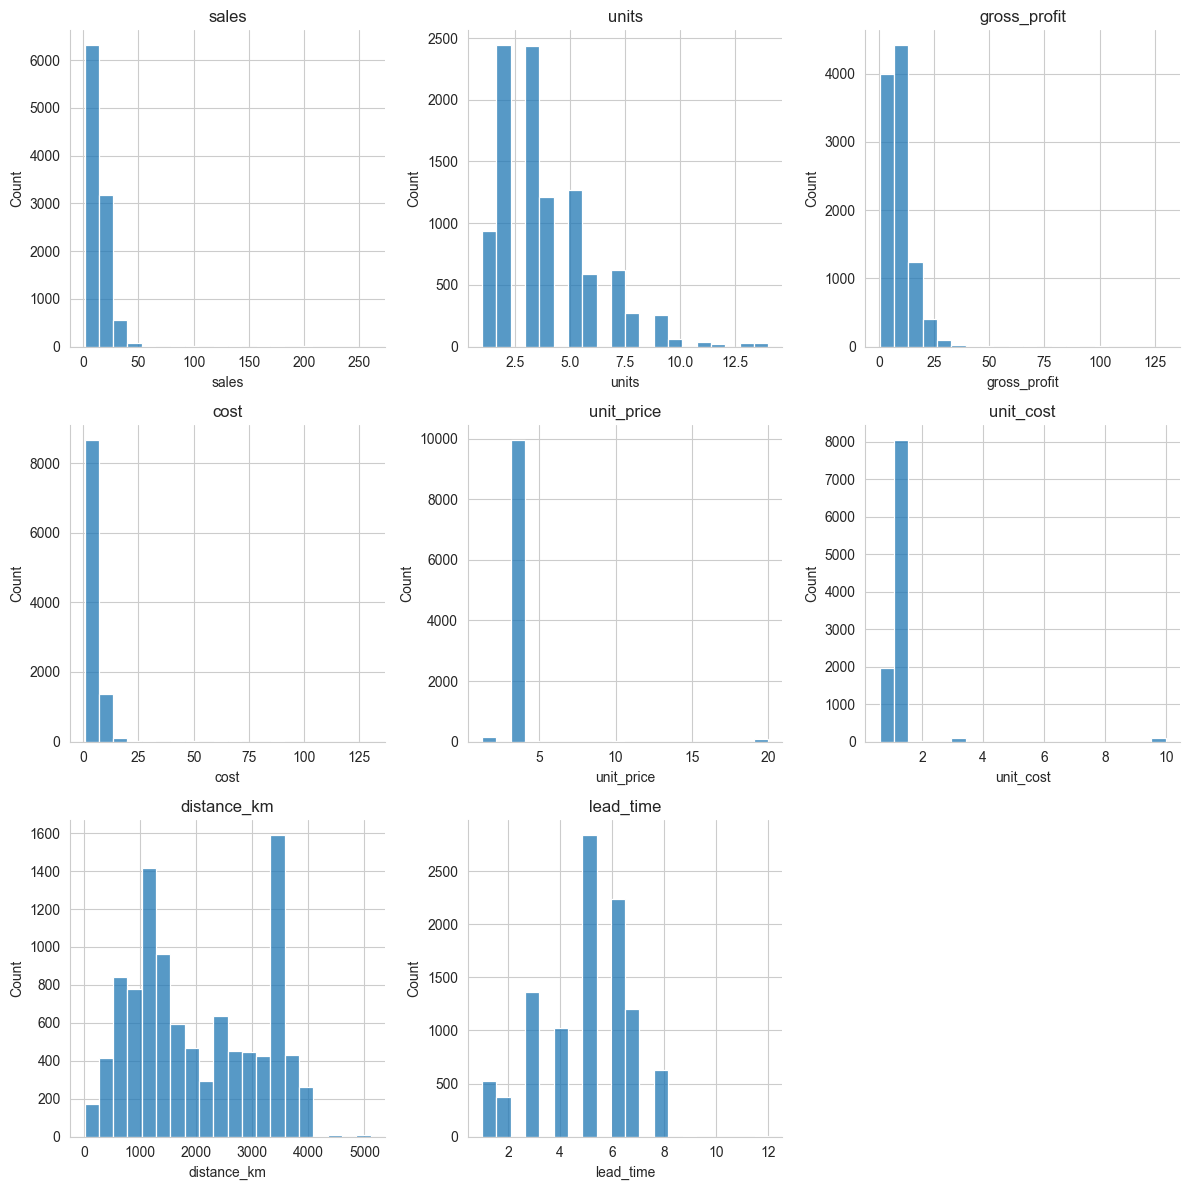

In [362]:
fig = plt.figure(figsize=(12, 12))
for i, col in enumerate(continuous_cols):
    ax = fig.add_subplot(3, 3, i+1)
    sns.histplot(data=df_encoded, x=col, bins=20)
    ax.set_title(col)
    
plt.tight_layout()
sns.despine()
plt.show()

### Visualize - Boxplot

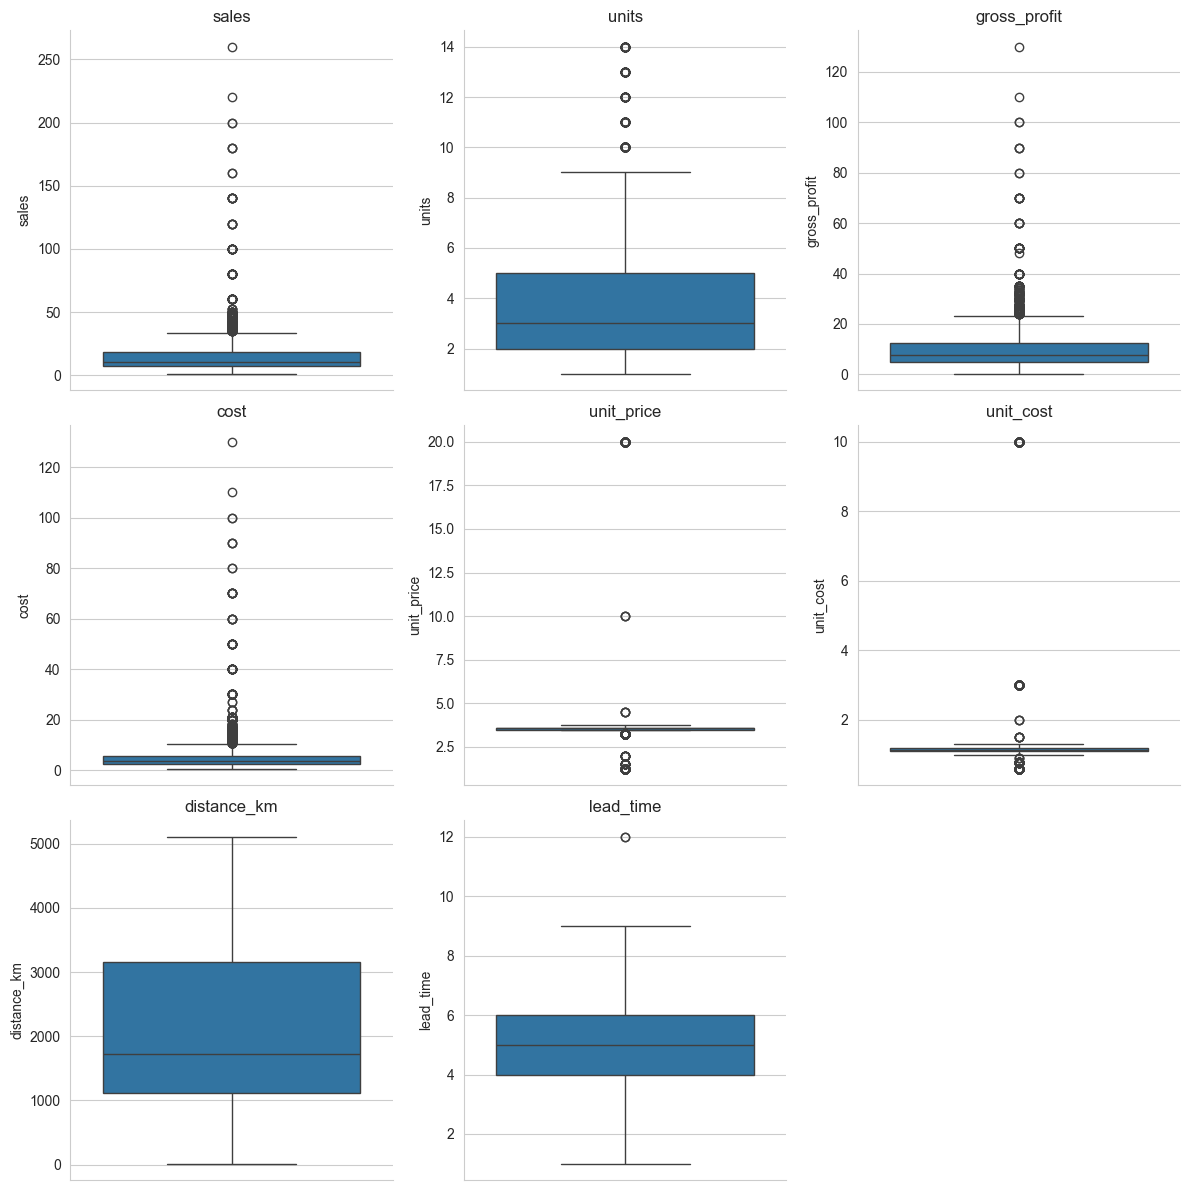

In [363]:
fig = plt.figure(figsize=(12, 12))
for i, col in enumerate(continuous_cols):
    ax = fig.add_subplot(3, 3, i+1)
    sns.boxplot(data=df_encoded, y=col)
    ax.set_title(col)
    
plt.tight_layout()
sns.despine()
plt.show()

### Check Outlier Count Per Column

In [364]:
for col in continuous_cols:
    quartiles = np.percentile(df_encoded[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((df_encoded[col] < lower_bound) | (df_encoded[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")
    
print(f'Total number of entries: {df_encoded.shape[0]}')

The sales column has 245 according to the boxplot method.
The units column has 175 according to the boxplot method.
The gross_profit column has 217 according to the boxplot method.
The cost column has 397 according to the boxplot method.
The unit_price column has 2481 according to the boxplot method.
The unit_cost column has 346 according to the boxplot method.
The distance_km column has 0 according to the boxplot method.
The lead_time column has 2 according to the boxplot method.
Total number of entries: 10194
